# Capacitated Facility Location Problem - Version #6

In [96]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

In [97]:
version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [98]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [99]:
# Define the capacities of digester
medium_digester_capacity = 78480  # in tonne/yr
large_digester_capacity = 150560  # in tonne/yr

# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [100]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [101]:
# Create mock digester capacity data 
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data (f_j)
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [102]:
# (q_j)
max_capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500}
# (f_j)
fixed_cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [103]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [104]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # set F
Plant = potential_digester_location.index.tolist() # set P

In [105]:
# (p_i)
manure_production = farm['manure_t'].to_dict()  

# Define the total manure production by all farms (alpha)
total_manure = sum(manure_production[i] for i in Farm)

In [107]:
# Open the file for reading
with open("./transportation_cost.txt", "r") as fp:
    # Load the dictionary from the file
    transport_cost = json.load(fp)

# Function to recursively convert dictionary keys to integers
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(key) if key.isdigit() else key: convert_keys_to_int(value) for key, value in data.items()}
    else:
        return data

# Convert the keys to integers
transport_cost = convert_keys_to_int(transport_cost) # C_ij

In [108]:
for key, value in transport_cost.items():
    print(f"{key}: {value}")

0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643696, 42: 12.07342535564

In [123]:
# Define manure use goal (mu)
target = 0.2

In [111]:
def cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure):
    """
    Input
    * Plant: list (sets/array) of facility indices
    * Farm: list (sets/array) of customer indices
    * fixed_cost: dictionary of fixed cost of each Plant - {Plant:fixed cost}
    * transport_cost: nested dictionary of shortest paths (OD matrix) from all Farm to all Plant - {Plant:{Farm:distance}}
    * manure_production: quantity of manure in each Farm - {Farm:manure quantity}
    * max_capacity: maximum capacity of each Plant - {Plant:max capacity}
    * target: float of manure use goal defined as policy
    * total_manure: total manure produced by all Farm
    """

    # Setting the Problem
    prob = LpProblem("Capacitated_Facility_Location_Problem", LpMinimize)

    # Defining our Decision Variables
    use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary) 
    ser_farm = LpVariable.dicts("Farm_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary) 

    # Objective Function
    prob += lpSum(fixed_cost[j]*use_plant[j] for j in Plant) + lpSum(transport_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # Costraints
    for i in Farm:
        prob += lpSum(ser_farm[(i, j)] for j in Plant) <= 1 # Very strange, the model becomes infeasible  if it's == 1, maybe because now the constraint has relaxed and not all farms need to be assigned to facility, which will be the case if ==1

    # The capacity constraint here it differnt than the one in paper, but i think it does the work still
    for j in Plant:
        prob += lpSum(manure_production[i] * ser_farm[(i,j)] for i in Farm) <= max_capacity[j]*use_plant[j]

    # Not really sure what this constraint does, I think it makes sure a farm can only be assigned to a facility given it's open, hence the value of xij is smaller or equal to yj 
    for i in Farm:
        for j in Plant:
            prob += ser_farm[(i,j)] <= use_plant[j]

    # Add a constraint to ensure at least x% of total manure production is sent to plants
    prob += lpSum(manure_production[i] * ser_farm[(i, j)] for i in Farm for j in Plant) >= target * total_manure

    # Solve 
    prob.solve()
    print("Solution Status = ", LpStatus[prob.status])

    """ Solution Outputs """
    
    # # Solution matrix
    # assignment_matrix = pd.DataFrame(index=Farm, columns=Plant)
    # for i in Plant:
    #     for j in Farm:
    #         assignment_matrix.at[j, i] = ser_farm[(j, i)].varValue

    # Solution dictionary
    # Initialize lists to store assignment information
    assignment_decision = {j: [] for j in Plant}

    # Collect assigned farms
    for i in Plant:
        for j in Farm:
            if ser_farm[(j,i)].varValue > 0.00001:
                assignment_decision[i].append(j)
    
    # Get total cost
    total_cost = pulp.value(prob.objective)

    # Extracting the values of the decision variables
    use_plant_index = {j: use_plant[j].varValue for j in Plant}
    ser_farm_index = {(i, j): ser_farm[(i, j)].varValue for i in Farm for j in Plant}

    # Calculating total fixed cost
    total_fixed_cost = sum(fixed_cost[j] * use_plant_index[j] for j in Plant)

    # Calculating total transportation cost
    total_transport_cost = sum(transport_cost[j][i] * ser_farm_index[(i, j)] for j in Plant for i in Farm)
    
    return total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index # assignment_matrix,

In [124]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/d3d32705fe3a4433b0c86464ab443e75-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/d3d32705fe3a4433b0c86464ab443e75-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.03

Solution Status =  Infeasible


In [37]:
# Print the assignment of clients to plants
# for i in Farm:
#     for j in Plant:
#         if ser_farm[(i, j)].varValue > 0 :
#             print(f"Assign {i} to {j}")

In [451]:
# Check if the opened plants are under-utilized
potential_digester_location['allocated_manure'] = assignment_matrix.sum(axis = 0)
potential_digester_location

,x,y,capacity,cost,allocated_manure,percentage_utilized
0,6.870686,52.215190,78480,209249,0.0,0.000000
1,6.554937,52.254895,78480,209249,0.0,0.000000
2,6.730518,52.252885,150560,252616,23.0,0.015276
3,6.914234,52.387401,150560,252616,0.0,0.000000
4,6.664105,52.392622,150560,252616,0.0,0.000000


In [176]:
x = 1214
new = str(121)

In [160]:
new

'121'

In [177]:
str(x)[::-1]

'4121'

In [173]:
action = slice(None, None, -1) 

In [174]:
sliced = new[action]
sliced

'121'

In [175]:
bool(new == sliced)

True

In [162]:
len(new)

3

In [163]:
new[2]

'1'

In [452]:
# Find the percentage of plant's capacity that is utilized 

potential_digester_location['percentage_utilized'] = 0

for index, row in potential_digester_location.iterrows():
    if row['allocated_manure'] > 0:
        potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_9153/3950044958.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.015276301806588734' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100


In [113]:
def find_farm_not_in_solution_plant_in_solution(assignment_decision, Farm, use_plant_index):
    """
    Input:
        : dictionary of model output {plant:[all the assigned farms]}
        Farm: list (sets/array) of customer indices
        use_plant_index: {Plant index:0 or 1}

    Return:
        empty_keys_unused_plant: a list of indices of unused plants
        farm_not_in_solution: a list of indices of excluded farms
    """
    
    # Find plants that in the optimal solution
    plant_in_use = []
    
    # for key, value in assignment_decision.items():
    #     if value is not None and not (
    #         (isinstance(value, str) and value.strip() == '') or
    #         (isinstance(value, (list, dict)) and not value)
    #     ):
    #         plant_in_use.append(key)
    for key, value in use_plant_index.items():
        if value > 0:
            plant_in_use.append(key)
    
    # Find farms that are excluded in the optimal solution aka. it is not assigned to any plants
    # Append the lists from the dictionary to a combined list
    combined_dict = []

    for key in assignment_decision:
        combined_dict.extend(assignment_decision[key])
    
    farm_not_in_solution = []

    for i in Farm:
        if i not in combined_dict:
            farm_not_in_solution.append(i)

    # Sanity check - check if there are duplicates in combined_dict (a farm is assigned to more than one plant)
    # Initialize a dictionary to store seen values
    seen = {}
    # Initialize a list to store duplicate values
    duplicates = []

    # Iterate through the list
    for item in combined_dict:
        # If the item is already in the dictionary, it's a duplicate
        if item in seen:
            duplicates.append(item)
        else:
            seen[item] = True
    if duplicates:
        print("Duplicate values:", duplicates)
    else:
        print("There are no duplicates in the list.")
    
    return plant_in_use, farm_not_in_solution 

plant_in_use is not used atm, because all plants are plotted. 

In [114]:
def plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False):
    
    # Get farm_not_in_solution 
    plant_in_use, farm_not_in_solution = find_farm_not_in_solution_plant_in_solution(assignment_decision, Farm, use_plant_index)

    # Visualize the results
    plt.figure(figsize=(8, 6))
    
    for i in Plant:
        plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=50, c='Black')
        # label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
        label = f"Digester {i}"
        plt.annotate(label, # this is the text
                    (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(-20,10), # distance from text to points (x,y)
                    ha='left', va='bottom') # horizontal alignment can be left, right or center 

    # Plot farms in solution
    for j in Plant:
        assigned = assignment_decision[j]
        plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Farm assigned to Digester {j}", marker='o', s=30, alpha=0.5)

    # Plot farms excluded in solution
    for i in farm_not_in_solution:
        plt.scatter(farm.loc[i, 'x'], farm.loc[i, 'y'], marker='o', s=30, c='Grey', alpha=0.5)

    # Add labels and legend
    plt.xlabel("Longtitude")
    plt.ylabel("Latitude")
    plt.title(f"Manure Use: {int(target*100)}%  Total cost: €{int(total_cost)}", loc='left')
    legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if save_fig:
        plt.savefig(filename, dpi=400, bbox_extra_artists=(legend,), bbox_inches='tight')
    
    plt.show()

In [66]:
filename = f"./outputs/cflp_v{version_number}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


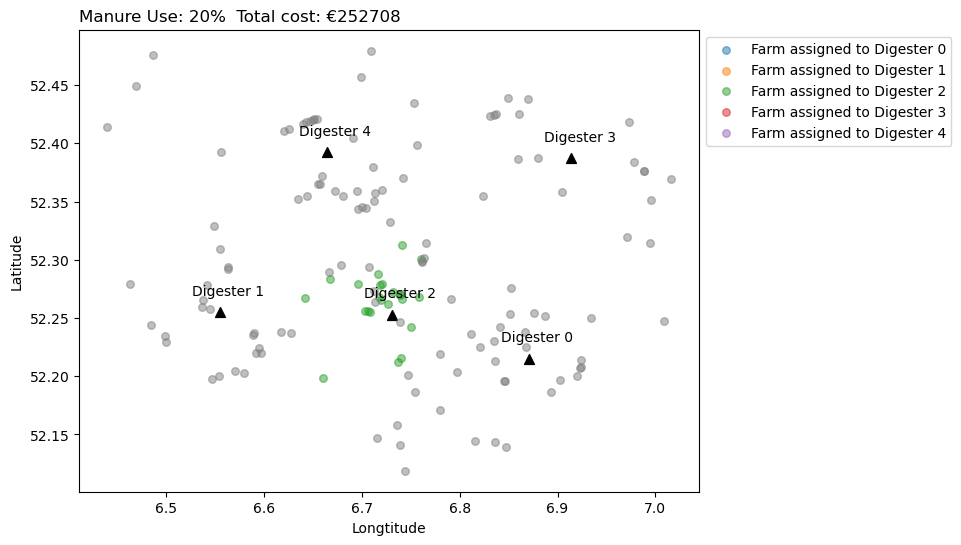

In [115]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [134]:
cost_compare = []
for i in np.arange(0.1, 0.9, 0.05):
    target = i 
    total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)
    cost_compare.append({'Index':i, 'total_cost':total_cost, 'total_fixed_cost':total_fixed_cost, 'total_transport_cost':total_transport_cost})

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/86bd63ab1ca64cc59ba174a806effe46-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/86bd63ab1ca64cc59ba174a806effe46-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 118321 - 0.00 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 49 integers unsatisfied sum - 22.9174
Cbc

In [136]:
cost_compare = pd.DataFrame(cost_compare)

In [148]:
# Calculating percentages for each row
cost_compare['fixed_cost_percentage'] = cost_compare['total_fixed_cost'] / cost_compare['total_cost'] * 100
cost_compare['transport_cost_percentage'] = cost_compare['total_transport_cost'] / cost_compare['total_cost'] * 100


In [149]:
cost_compare

,Index,total_cost,total_fixed_cost,total_transport_cost,fixed_cost_percentage,transport_cost_percentage
0,0.10,2.092979e+05,209249.0,48.858477,99.976656,0.023344
1,0.15,2.526729e+05,252616.0,56.941799,99.977464,0.022536
2,0.20,2.527082e+05,252616.0,92.200444,99.963515,0.036485
3,0.25,4.619682e+05,461865.0,103.221265,99.977656,0.022344
4,0.30,4.620051e+05,461865.0,140.135730,99.969668,0.030332
5,0.35,5.053955e+05,505232.0,163.526604,99.967644,0.032356
6,0.40,5.054394e+05,505232.0,207.420867,99.958962,0.041038
7,0.45,7.146917e+05,714481.0,210.682650,99.970521,0.029479
8,0.50,7.147338e+05,714481.0,252.780153,99.964633,0.035367
9,0.55,7.581810e+05,757848.0,333.025672,99.956076,0.043924


In [153]:
cost_compare[['Index', 'fixed_cost_percentage',	'transport_cost_percentage']]

,Index,fixed_cost_percentage,transport_cost_percentage
0,0.10,99.976656,0.023344
1,0.15,99.977464,0.022536
2,0.20,99.963515,0.036485
3,0.25,99.977656,0.022344
4,0.30,99.969668,0.030332
5,0.35,99.967644,0.032356
6,0.40,99.958962,0.041038
7,0.45,99.970521,0.029479
8,0.50,99.964633,0.035367
9,0.55,99.956076,0.043924


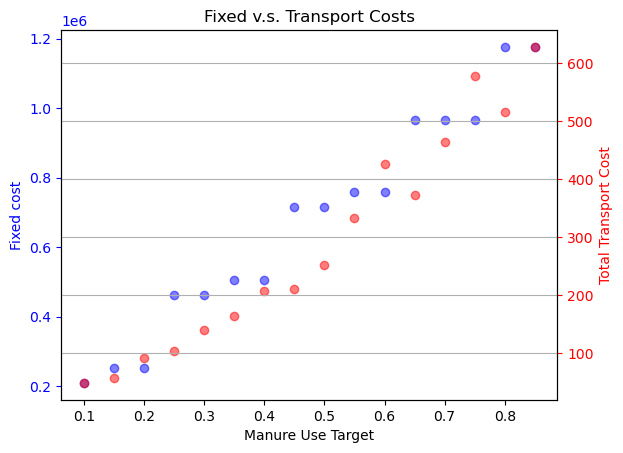

In [152]:
# Creating the figure and the first subplot
fig, ax1 = plt.subplots()

# Creating the scatter plot for the first y-axis
ax1.scatter(cost_compare['Index'], cost_compare['total_fixed_cost'], color='b', alpha=0.5)
ax1.set_xlabel('Manure Use Target')
ax1.set_ylabel('Fixed cost', color='b')
ax1.tick_params('y', colors='b')

# Creating the second subplot
ax2 = ax1.twinx()

# Creating the scatter plot for the second y-axis
ax2.scatter(cost_compare['Index'], cost_compare['total_transport_cost'], color='r', alpha=0.5)
ax2.set_ylabel('Total Transport Cost', color='r')
ax2.tick_params('y', colors='r')

# # Adding a legend
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Adding title and grid
plt.title('Fixed v.s. Transport Costs')
plt.grid(True)

# Display the plot
plt.show()

In [144]:
cost_compare

,Index,total_cost,total_fixed_cost,total_transport_cost
0,0.10,2.092979e+05,209249.0,48.858477
1,0.15,2.526729e+05,252616.0,56.941799
2,0.20,2.527082e+05,252616.0,92.200444
3,0.25,4.619682e+05,461865.0,103.221265
4,0.30,4.620051e+05,461865.0,140.135730
5,0.35,5.053955e+05,505232.0,163.526604
6,0.40,5.054394e+05,505232.0,207.420867
7,0.45,7.146917e+05,714481.0,210.682650
8,0.50,7.147338e+05,714481.0,252.780153
9,0.55,7.581810e+05,757848.0,333.025672
